# MODUALR RAG WITH QDRANT , GPT-5 AND PyMuPDF , LLAMAINDEX

## Parsing the pdf 

In [159]:
import pymupdf  # PyMuPDF
import pytesseract
from PIL import Image
import io
import os
from pathlib import Path
from typing import List, Dict, Any
from dataclasses import dataclass
from datetime import datetime

@dataclass
class ExtractedContent:
    """Container for extracted PDF content"""
    texts: List[Dict[str, Any]]
    tables: List[Dict[str, Any]]
    images: List[Dict[str, Any]]

class PDFParser:
    """Simple PDF parser for extracting text, tables, and images"""
    
    def __init__(self, output_dir: str = "extracted", save_as_markdown: bool = True, use_ocr: bool = False):
        """
        Initialize PDF Parser
        
        Args:
            output_dir: Directory to save extracted content
            save_as_markdown: Whether to save text content as markdown
            use_ocr: Whether to use OCR for text extraction
        """
        self.output_dir = output_dir
        self.save_as_markdown = save_as_markdown
        self.use_ocr = use_ocr
        
        # Create output directories
        self.text_dir = os.path.join(output_dir, "texts")
        self.table_dir = os.path.join(output_dir, "tables")
        self.image_dir = os.path.join(output_dir, "images")
        
        os.makedirs(self.text_dir, exist_ok=True)
        os.makedirs(self.table_dir, exist_ok=True)
        os.makedirs(self.image_dir, exist_ok=True)
    
    def parse_pdf(self, pdf_path: str) -> ExtractedContent:
        """Parse a single PDF file"""
        results = self.parse_pdfs([pdf_path])
        return results.get(pdf_path, ExtractedContent([], [], []))
    
    def parse_pdfs(self, pdf_paths: List[str]) -> Dict[str, ExtractedContent]:
        """Parse multiple PDF files"""
        results = {}
        
        for pdf_path in pdf_paths:
            print(f"Processing: {pdf_path}")
            try:
                content = self._extract_content(pdf_path)
                results[pdf_path] = content
                self._save_to_files(pdf_path, content)
            except Exception as e:
                print(f"Error processing {pdf_path}: {e}")
                results[pdf_path] = ExtractedContent([], [], [])
        
        return results
    
    def _extract_content(self, pdf_path: str) -> ExtractedContent:
        """Extract content from a PDF file"""
        texts = []
        tables = []
        images = []
        
        doc = pymupdf.open(pdf_path)
        
        for page_num, page in enumerate(doc, 1):
            # Extract text
            if self.use_ocr:
                text_content = self._extract_text_with_ocr(page)
            else:
                text_content = page.get_text()
            
            if text_content.strip():
                texts.append({
                    'page': page_num,
                    'content': text_content,
                    'metadata': {
                        'source': pdf_path,
                        'extraction_method': 'ocr' if self.use_ocr else 'native'
                    }
                })
            
            # Extract tables
            try:
                table_finder = page.find_tables()
                for table_idx, table in enumerate(table_finder.tables):
                    table_data = table.extract()
                    if table_data:
                        tables.append({
                            'page': page_num,
                            'table_data': table_data,
                            'metadata': {
                                'source': pdf_path,
                                'table_index': table_idx
                            }
                        })
            except Exception as e:
                print(f"Could not extract tables from page {page_num}: {e}")
            
            # Extract images
            image_list = page.get_images(full=True)
            for img_index, img in enumerate(image_list):
                try:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    img_bytes = base_image["image"]
                    img_ext = base_image["ext"]
                    
                    images.append({
                        'page': page_num,
                        'image_bytes': img_bytes,
                        'metadata': {
                            'source': pdf_path,
                            'index': img_index,
                            'format': img_ext,
                            'size_bytes': len(img_bytes)
                        }
                    })
                except Exception as e:
                    print(f"Could not extract image {img_index} from page {page_num}: {e}")
        
        doc.close()
        return ExtractedContent(texts=texts, tables=tables, images=images)
    
    def _extract_text_with_ocr(self, page):
        """Extract text using OCR"""
        try:
            # Render page to image
            mat = pymupdf.Matrix(2, 2)  # 2x zoom for better OCR
            pix = page.get_pixmap(matrix=mat)
            img_data = pix.tobytes("png")
            
            # Perform OCR
            image = Image.open(io.BytesIO(img_data))
            ocr_text = pytesseract.image_to_string(image, lang='eng')
            return ocr_text
        except Exception as e:
            print(f"OCR failed, falling back to native extraction: {e}")
            return page.get_text()
    
    def _save_to_files(self, pdf_path: str, content: ExtractedContent):
        """Save extracted content to files"""
        pdf_name = Path(pdf_path).stem
        
        # Save texts
        if content.texts:
            if self.save_as_markdown:
                text_file = os.path.join(self.text_dir, "texts.md")
                mode = 'a' if os.path.exists(text_file) else 'w'
                with open(text_file, mode, encoding='utf-8') as f:
                    f.write(f"# Extracted Text from {pdf_name}\n\n")
                    for text_data in content.texts:
                        f.write(f"## Page {text_data['page']}\n\n")
                        f.write(text_data['content'])
                        f.write("\n\n---\n\n")
            else:
                text_file = os.path.join(self.text_dir, "texts.txt")
                mode = 'a' if os.path.exists(text_file) else 'w'
                with open(text_file, mode, encoding='utf-8') as f:
                    for text_data in content.texts:
                        f.write(f"=== {pdf_name} - Page {text_data['page']} ===\n")
                        f.write(text_data['content'])
                        f.write("\n\n")
        
        # Save tables
        if content.tables:
            existing_tables = [f for f in os.listdir(self.table_dir) if f.startswith('table_') and f.endswith('.md')]
            next_num = len(existing_tables) + 1
            
            for table_data in content.tables:
                table_file = os.path.join(self.table_dir, f"table_{next_num}.md")
                with open(table_file, 'w', encoding='utf-8') as f:
                    f.write(f"# Table {next_num}\n")
                    f.write(f"**Source:** {pdf_name}\n")
                    f.write(f"**Page:** {table_data['page']}\n\n")
                    f.write(self._table_to_markdown(table_data['table_data']))
                next_num += 1
        
        # Save images
        if content.images:
            for img_data in content.images:
                img_filename = f"images_p{img_data['page']}_img{img_data['metadata']['index']}.{img_data['metadata']['format']}"
                img_path = os.path.join(self.image_dir, img_filename)
                with open(img_path, 'wb') as f:
                    f.write(img_data['image_bytes'])
    
    def _table_to_markdown(self, table_data: List[List[str]]) -> str:
        """Convert table data to markdown format"""
        if not table_data or not table_data[0]:
            return ""
        
        markdown = []
        
        # Header
        markdown.append("| " + " | ".join(str(cell) for cell in table_data[0]) + " |")
        markdown.append("|" + "|".join(["---"] * len(table_data[0])) + "|")
        
        # Rows
        for row in table_data[1:]:
            markdown.append("| " + " | ".join(str(cell) for cell in row) + " |")
        
        return "\n".join(markdown)

In [160]:
parser = PDFParser(
        output_dir="extracted",
        save_as_markdown=True,
        use_ocr=False  # Set to True if you need OCR
    )
    
    # Parse PDFs
pdf_files = ["./Documents/1706.03762v7.pdf"]
results = parser.parse_pdfs(pdf_files)
    
    # Access results
for pdf_path, content in results.items():
        print(f"\nPDF: {pdf_path}")
        print(f"  Text pages: {len(content.texts)}")
        print(f"  Tables found: {len(content.tables)}")
        print(f"  Images extracted: {len(content.images)}")

Processing: ./Documents/1706.03762v7.pdf

PDF: ./Documents/1706.03762v7.pdf
  Text pages: 15
  Tables found: 5
  Images extracted: 3


## Getting the data sorted 

In [161]:
## Image documents 
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader

image_documents = SimpleDirectoryReader("./extracted/images").load_data()

In [162]:
## Sorting the text into chunks 
text_documents = SimpleDirectoryReader("./extracted/texts").load_data()

In [65]:
## Table documents 
table_documents = SimpleDirectoryReader("./extracted/tables").load_data()

## Setting up the Qdrant client 

In [ ]:
import qdrant_client
client = qdrant_client.QdrantClient(path = "./tmp/llama_multimodal")

In [132]:
## Crateing the text, table and image Store 
from llama_index.vector_stores.qdrant import QdrantVectorStore

text_store = QdrantVectorStore(
    client  = client,
    collection_name = "text_collection"
)
image_store = QdrantVectorStore(
    client = client,
    collection_name = "image_collection"
)
table_store = QdrantVectorStore(
    client = client , 
    collection_name = "table_collection"
)

## Setting the Vector Store for retrieval 

In [ ]:
from llama_index.core import StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create storage context with all stores
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store,
    
)

# Combine all documents for indexing
all_documents = text_documents + image_documents + table_documents

# Create the multimodal index with all documents
index = MultiModalVectorStoreIndex.from_documents(
    documents=all_documents,
    storage_context=storage_context,
)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
openai_mm_llm = OpenAIMultiModal(model="gpt-5",api_key=os.getenv("OPENAI_API_KEY"), max_new_tokens=300)

C:\Users\KARAN\AppData\Local\Temp\ipykernel_13528\3038661835.py:3: DeprecationWarning: Call to deprecated class OpenAIMultiModal. (The package has been deprecated and will no longer be maintained. Please use llama-index-llms-openai (preferably the Responses API) instead. See Multi Modal LLMs documentation for a complete guide on migration: https://docs.llamaindex.ai/en/stable/understanding/using_llms/using_llms/#multi-modal-llms) -- Deprecated since version 0.5.2.
  openai_mm_llm = OpenAIMultiModal(model="gpt-4o",api_key=os.getenv("OPENAI_API_KEY"), max_new_tokens=300)


## Generation

In [147]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "What are the figures provided in the paper and what are they about ?"
response = query_engine.query(query_str)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [148]:
response

Response(response='The figures provided in the paper are diagrams related to the Transformer model architecture:\n\n1. **First Figure**: This diagram illustrates the scaled dot-product attention mechanism. It shows the process of calculating attention scores using queries (Q), keys (K), and values (V). The steps include matrix multiplication, scaling, optional masking, applying the softmax function, and a final matrix multiplication.\n\n2. **Second Figure**: This diagram represents the overall architecture of the Transformer model. It includes the encoder and decoder stacks, each with multiple layers (denoted as Nx). The encoder consists of multi-head attention and feed-forward layers with add and norm operations. The decoder includes masked multi-head attention, multi-head attention, and feed-forward layers, also with add and norm operations. Positional encoding is added to the input and output embeddings.\n\nThese figures are essential for understanding how the Transformer processes 

In [149]:
print(str(response))

The figures provided in the paper are diagrams related to the Transformer model architecture:

1. **First Figure**: This diagram illustrates the scaled dot-product attention mechanism. It shows the process of calculating attention scores using queries (Q), keys (K), and values (V). The steps include matrix multiplication, scaling, optional masking, applying the softmax function, and a final matrix multiplication.

2. **Second Figure**: This diagram represents the overall architecture of the Transformer model. It includes the encoder and decoder stacks, each with multiple layers (denoted as Nx). The encoder consists of multi-head attention and feed-forward layers with add and norm operations. The decoder includes masked multi-head attention, multi-head attention, and feed-forward layers, also with add and norm operations. Positional encoding is added to the input and output embeddings.

These figures are essential for understanding how the Transformer processes input data and generates 

In [150]:
query_str = "Explain figure 1 of the paper "
response = query_engine.query(query_str)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [153]:
response

Response(response="Figure 1 illustrates the architecture of the Transformer model, which consists of an encoder and a decoder. \n\n### Encoder:\n- **Input Embedding**: Converts input tokens into vectors.\n- **Positional Encoding**: Adds positional information to the embeddings.\n- **Multi-Head Attention**: Allows the model to focus on different parts of the input sequence.\n- **Add & Norm**: Applies residual connections followed by layer normalization.\n- **Feed Forward**: A fully connected feed-forward network applied to each position.\n- The encoder stack is repeated \\(N\\) times.\n\n### Decoder:\n- **Output Embedding**: Converts output tokens into vectors.\n- **Positional Encoding**: Adds positional information to the embeddings.\n- **Masked Multi-Head Attention**: Prevents attending to future tokens in the sequence.\n- **Multi-Head Attention**: Attends to the encoder's output.\n- **Add & Norm**: Similar to the encoder, applies residual connections and normalization.\n- **Feed Forw

In [156]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./extracted/images"):
    image_paths.append(str(os.path.join("./input_images", img_path)))


In [157]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

<Figure size 1600x900 with 0 Axes>

**Node ID:** f5114728-3e69-463d-a530-2f61861031bf<br>**Similarity:** 0.7845652676079917<br>**Text:** arXiv preprint
arXiv:1308.0850, 2013.
[11] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for im-
age recognition. In Proceedings of the IEEE Conference on Compute...<br>

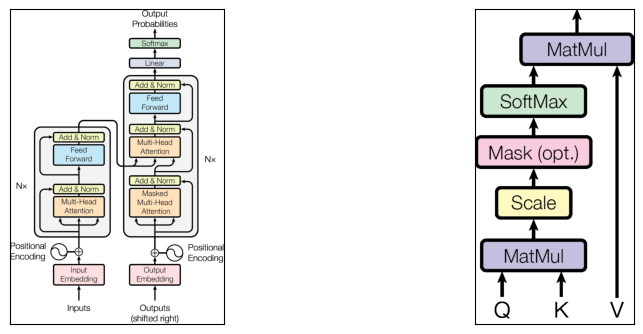

In [158]:
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [152]:
print(str(response))

Figure 1 illustrates the architecture of the Transformer model, which consists of an encoder and a decoder. 

### Encoder:
- **Input Embedding**: Converts input tokens into vectors.
- **Positional Encoding**: Adds positional information to the embeddings.
- **Multi-Head Attention**: Allows the model to focus on different parts of the input sequence.
- **Add & Norm**: Applies residual connections followed by layer normalization.
- **Feed Forward**: A fully connected feed-forward network applied to each position.
- The encoder stack is repeated \(N\) times.

### Decoder:
- **Output Embedding**: Converts output tokens into vectors.
- **Positional Encoding**: Adds positional information to the embeddings.
- **Masked Multi-Head Attention**: Prevents attending to future tokens in the sequence.
- **Multi-Head Attention**: Attends to the encoder's output.
- **Add & Norm**: Similar to the encoder, applies residual connections and normalization.
- **Feed Forward**: A fully connected network simi